First, let's import the modules we need.

In [16]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import networkx as nx
import matplotlib.pyplot as plt
import collections
import tensorflow as tf
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
import json
import os
import random
from tensorflow.keras.models import load_model
import time
from sklearn.metrics import accuracy_score
import re



os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
NUM_CLIENTS = 51
NUM_CLASSES = 18
LOCAL_EPOCHS = 1
NUM_ROUNDS = 20
LEARNING_RATE = 0.01


Let's define some helper functions to segment the timeseries data to segments of 25 datapoints, with each having a 10-datapoint overlap with the previous and next segments. All the segments have purely the same activity label.

In [17]:
import numpy as np

def segment_data(df, window_size=50, step_size=25):
    segments = []
    labels = []
    for start in range(0, len(df) - window_size, step_size):
        end = start + window_size
        segment = df.iloc[start:end]
        if len(segment) == window_size:
            segment_data = segment[["x", "y", "z"]].values
            segments.append(segment_data)
            label = segment["activity"].mode()[0]
            labels.append(label)
    return np.array(segments), np.array(labels)

def segment_each_activity(df, window_size=25, step_size=15):
    all_segments = []
    all_labels = []
    for activity in df["activity"].unique():
        activity_data = df[df["activity"] == activity]
        
        segments, labels = segment_data(activity_data, window_size, step_size)
        
        all_segments.append(segments)
        all_labels.append(labels)

    all_segments = np.concatenate(all_segments, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_segments, all_labels


Read the data and encode the activity label, do this same for each user and make a big array consisting of these local datasets. Also, let's create a dictionary to create human-readable labels for the activities according to the [dataset description](https://archive.ics.uci.edu/ml/machine-learning-databases/00507/WISDM-dataset-description.pdf).

In [18]:
activity_dict = {1: "Walking", 2: "Jogging", 3: "Stairs", 4: "Sitting", 5: "Standing",
    6: "Typing", 7: "Brushing Teeth", 8: "Eating Soup", 9: "Eating Chips",
    10: "Eating Pasta", 11: "Drinking from Cup", 12: "Eating Sandwich",
    13: "Kicking (Soccer Ball)", 14: "Playing Catch w/Tennis Ball",
    15: "Dribbling (Basketball)", 16: "Writing", 17: "Clapping", 18: "Folding Clothes"
}

datasets = []
lencoder = LabelEncoder()
global_test_dataset = []

for uid in range(1600, 1600 + NUM_CLIENTS):
    ds = pd.read_csv(f"./raw/phone/accel/data_{uid}_accel_phone.txt", header=None, names=["user", "activity", "timestamp", "x", "y", "z"])
    ds["activity"] = lencoder.fit_transform(ds["activity"])
    ds["z"] = ds["z"].astype(str).str.replace(";", "", regex=False).astype(float)
    seg_X, seg_y = segment_each_activity(ds)
    X_train, X_test, y_train, y_test = train_test_split(seg_X, seg_y, test_size=0.3, shuffle=True, random_state=42)
    X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)
    sample_size = 0.95
    
    sample_size_train = int(sample_size * len(X_train))
    sample_size_test = int(1.0 * len(X_test))
    sample_size_validation = int(1.0 * len(X_validation))

    X_train = X_train[:sample_size_train]
    y_train = y_train[:sample_size_train]

    X_test = X_test[:sample_size_test]
    y_test = y_test[:sample_size_test]

    X_validation = X_validation[:sample_size_validation]
    y_validation = y_validation[:sample_size_validation]

    num_global_samples = max(1, int(0.05 * len(X_train)))
    global_test_dataset.extend(list(zip(X_train[-num_global_samples:], y_train[-num_global_samples:])))
    
    datasets.append([X_train, y_train, X_test, y_test, X_validation, y_validation])

global_X, global_y = zip(*global_test_dataset)
global_X = np.array(global_X)
global_y = np.array(global_y)

In [19]:
print("Shape of the global test dataset", global_X.shape)

Shape of the global test dataset (10584, 25, 3)


Let's create some helper functions for the next steps.

In [20]:
# Create sparse graph with random edges (redundant now)
def create_sparse_graph(num_clients=NUM_CLIENTS, k=5):
    G = nx.Graph()
    for i in range(num_clients):
        G.add_node(i)

    for i in range(num_clients):
        possible_neighbors = list(set(range(num_clients)) - {i} - set(G.neighbors(i)))
        random_neighbors = random.sample(possible_neighbors, min(k, len(possible_neighbors)))
        for j in random_neighbors:
            G.add_edge(i, j)
    
    
    return G

# Create and return a basic nx graph
def create_graph():
    G = create_sparse_graph(NUM_CLIENTS, 5)
    for i, (X_train, y_train, X_test, y_test, X_validation, y_validation) in enumerate(datasets):
        G.nodes[i]['X_train'] = X_train
        G.nodes[i]['y_train'] = y_train
        G.nodes[i]['X_test'] = X_test
        G.nodes[i]['y_test'] = y_test
        G.nodes[i]['X_validation'] = X_validation
        G.nodes[i]['y_validation'] = y_validation
    return G

# Create a basic CNN mode with number of our classes
def create_model(input_shape=(25,3), num_classes=18):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv1D(64, 3, activation='relu', name='conv1')(inputs)
    x = tf.keras.layers.Conv1D(32, 3, activation='relu', name='conv2')(x)
    x = tf.keras.layers.Conv1D(16, 3, activation='relu', name='conv3')(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='dense')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

Next, let's initialize the global model.

In [21]:
global_model = create_model()
initial_weights = global_model.get_weights()
global_model.summary()

G = create_graph()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 25, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv1D)                  │ (None, 23, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 21, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv1D)                  │ (None, 19, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 304)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │         5,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,858 (54.13 KB)

 Trainable params: 13,858 (54.13 KB)

 Non-trainable params: 0 (0.00 B)

This training process takes a long time - I have included a .weights.h5-file in the zip file in case you just wanna test out the final model. If you wanna skip the training progress - just set SKIP_TRAINING to True.

In [22]:
global_errors = []
start = time.time()
accuracies = []
losses = []
CLIENT_SUBSET_SIZE = 10
SKIP_TRAINING = True

 
if not SKIP_TRAINING:
    for r in range(NUM_ROUNDS):
        client_models = [None] * NUM_CLIENTS
        round_losses = []
        round_accuracies = []
        clients = list(G.nodes)

        selected_clients = random.sample(clients, CLIENT_SUBSET_SIZE)

        optimizer = tf.keras.optimizers.Adam()
        ce_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

        global_weights = global_model.get_weights()

        # Train the selected clients
        for i in selected_clients:
            client = G.nodes[i]
            X_train, y_train = client['X_train'], client['y_train']
            X_validation, y_validation = client['X_validation'], client['y_validation']

            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
            client_models[i] = create_model()
            client_models[i].compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            client_models[i].set_weights(global_weights)

            client_models[i].fit(X_train, y_train, epochs=LOCAL_EPOCHS, batch_size=32, verbose=0)
            print("Start training client", i)
            loss, acc = client_models[i].evaluate(X_validation, y_validation, verbose=0)
            print("Loss:", loss, ", acc:", acc)
            round_accuracies.append(acc)
            round_losses.append(loss)

        # Federated averaging
        avg_weights = []
        for j in range(len(global_weights)):
            weights = [client_models[k].get_weights()[j] for k in selected_clients]
            layer_mean = tf.math.reduce_mean(weights, axis=0)
            avg_weights.append(layer_mean)
        global_model.set_weights(avg_weights)

        # Global evaluation
        X_test, y_test = global_X, global_y
        global_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
        
        global_errors.append([loss, acc])
        print(f"Round {r+1} — Global Loss: {loss:.4f}, Accuracy: {acc:.4f}")
        
        losses.append(round_losses)
        accuracies.append(round_accuracies)
else:
    
    global_model.load_weights('final_global_model_second_round.weights.h5')
    
    X_test, y_test = global_X, global_y
    global_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
    print("Global loss", loss, " and acc", acc)



Global loss 4.975457668304443  and acc 0.14758124947547913


In [23]:
# Save the model if needed, and print the global errors.
# global_model.save_weights('final_global_model_second_round.weights.h5')
# print(global_errors)

The following plots only work with the data that has been collected from the whole training process, so they cannot be skipped. I have hardcoded the global errors for your convenience, and the local losses and accuracies.

Next, let's plot the accuracies and losses of both of the rounds of iterations with different parameters (see the paper for the parameter values used). The loss-acc values are hardcoded from the result logs.

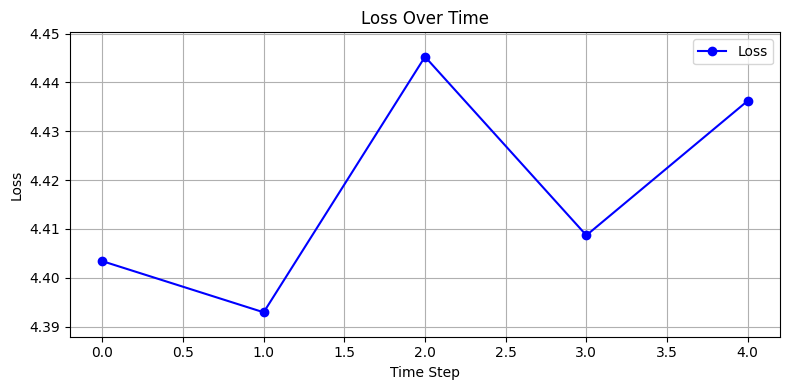

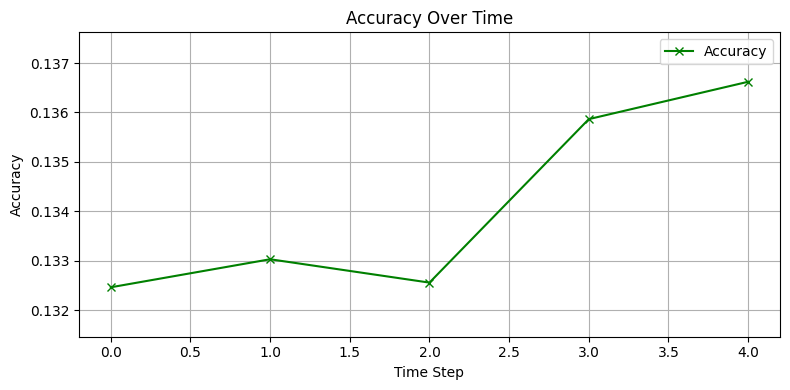

In [24]:
# First round of executions
errors = [[4.40338659286499, 0.13246409595012665], [4.392908573150635, 0.1330309957265854], [4.44524621963501, 0.13255858421325684], [4.4086761474609375, 0.1358654499053955], [4.436220645904541, 0.13662131130695343]]

loss = [e[0] for e in errors]
accuracy = [e[1] for e in errors]
time_steps = list(range(len(errors)))

plt.figure(figsize=(8, 4))
plt.plot(time_steps, loss, label="Loss", marker='o', color='blue')
plt.title("Loss Over Time")
plt.xlabel("Time Step")
plt.ylabel("Loss")
plt.ylim(min(loss) - 0.005, max(loss) + 0.005)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("primary_error_over_time.png")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(time_steps, accuracy, label="Accuracy", marker='x', color='green')
plt.title("Accuracy Over Time")
plt.xlabel("Time Step")
plt.ylabel("Accuracy")
plt.ylim(min(accuracy) - 0.001, max(accuracy) + 0.001)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("secondary_error_over_time.png")
plt.show()

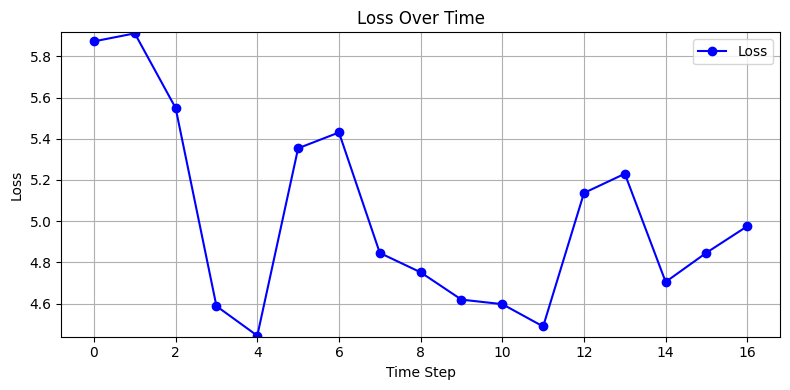

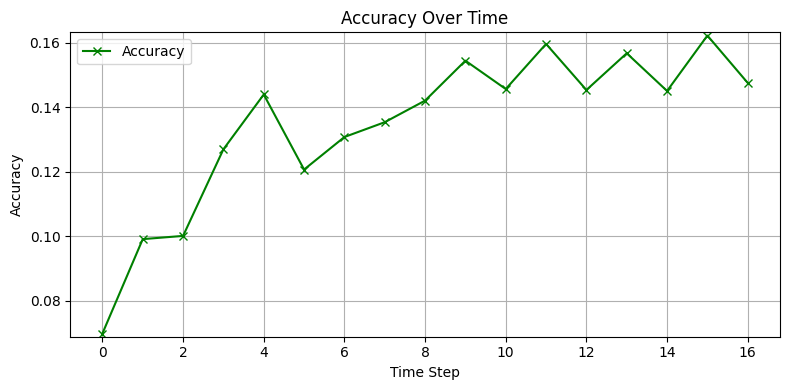

In [25]:
# Second round of executions (hardcoded loss and acc values)
errors = [[5.8725, 0.0698], [5.9114, 0.0991], [5.5491, 0.1001], [4.5877, 0.1270], [4.4441, 0.1440], [5.3537, 0.1207], [5.4305, 0.1308], [4.8457, 0.1354], [4.7517, 0.1421], [4.6191, 0.1545], [4.5972, 0.1457], [4.4888, 0.1597], [5.1368, 0.1454], [5.2301, 0.1568], [4.7050, 0.1451], [4.8469, 0.1623], [4.9755, 0.1476]]

loss = [e[0] for e in errors]
accuracy = [e[1] for e in errors]
time_steps = list(range(len(errors)))

plt.figure(figsize=(8, 4))
plt.plot(time_steps, loss, label="Loss", marker='o', color='blue')
plt.title("Loss Over Time")
plt.xlabel("Time Step")
plt.ylabel("Loss")
plt.ylim(min(loss) - 0.005, max(loss) + 0.005)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("primary_error_over_time.png")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(time_steps, accuracy, label="Accuracy", marker='x', color='green')
plt.title("Accuracy Over Time")
plt.xlabel("Time Step")
plt.ylabel("Accuracy")
plt.ylim(min(accuracy) - 0.001, max(accuracy) + 0.001)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("secondary_error_over_time.png")
plt.show()

Next, let's plot the loss/accuracy of the local models during the training rounds. THIS WONT RUN IF YOU SKIPPED THE TRAINING PROCESS.

In [26]:
# Round 1
accs = np.array(accuracies).reshape(51, 5)
losses = np.array(losses).reshape(51, 5)

mean1 = accs.mean(axis=0)
mean2 = losses.mean(axis=0)

rounds = np.arange(1, 6)
plt.plot(rounds, mean1, marker='o', label='Accuracy')
plt.plot(rounds, mean2, marker='s', label='Loss')
plt.xlabel('Training Round')
plt.ylabel('Average Value')
plt.title('Average per Round Across Clients')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



ValueError: cannot reshape array of size 0 into shape (51,5)